In [3]:
import pandas as pd
df = pd.read_csv('/home/kcv/Desktop/constant_power_test/stitched_detail_data/RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv')
df[['Cycle No', 'Step name', 'Step No']].drop_duplicates()

,Cycle No,Step name,Step No
0,1,Rest,1
31,1,CC_DChg,2
54,1,Rest,3
1855,1,CP_Chg,4
2933,1,CP_Chg,5
12450,1,CP_Chg,6
12455,1,Rest,7
14256,1,CP_DChg,8
14258,1,CP_DChg,9
16738,1,CP_DChg,10


In [3]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/constant_power_test/stitched_detail_data")
OUTPUT = Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")

summaries = []

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    df = pd.read_csv(csv_path)

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df["Current_abs_A"] = round(df["Current(A)"].abs(),2)
    df["Capacity_abs_Ah"] = df["Capacity(Ah)"].abs()
    df["Power_W"] = df["Power(mW)"].abs() / 1000

    df = df.sort_values(["Cycle No", "Absolute time", "Step No"])

    durations = (
        df.groupby(["Cycle No", "Step name", "Step No"], dropna=False)
          .agg(
              Start=("Absolute time", "min"),
              End=("Absolute time", "max"),
              Current_min=("Current_abs_A", "min"),
              Current_max=("Current_abs_A", "max"),
              Capacity_min=("Capacity_abs_Ah", "min"),
              Capacity_max=("Capacity_abs_Ah", "max"),
              Volt_min=("volt(V)", "min"),
              Volt_max=("volt(V)", "max"),
              Power_min_W=("Power_W", "min"),
              Power_max_W=("Power_W", "max"),
          )
    )

    durations["Duration_s"] = (durations["End"] - durations["Start"]).dt.total_seconds().round()
    durations["c_rate"] = (durations["Current_max"] / 150).round(2)

    summary = durations.reset_index()
    summary.insert(0, "Cell", csv_path.stem)
    summaries.append(summary)

eda_summary = pd.concat(summaries, ignore_index=True)
eda_summary.to_csv(OUTPUT, index=False)
print(f"Saved summary for {len(summaries)} cells to {OUTPUT}")


Saved summary for 21 cells to /home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv


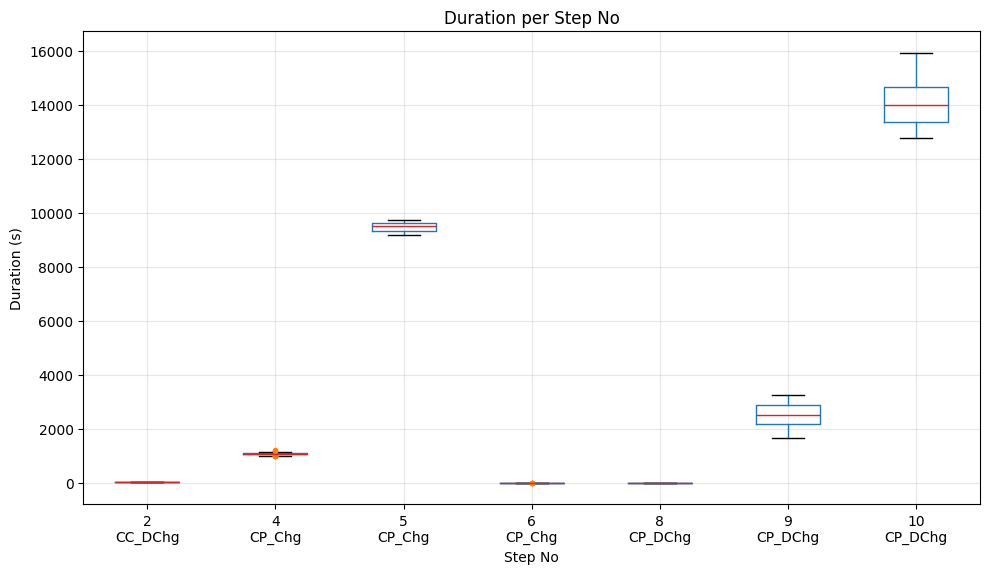

In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)
summary = summary[summary["Step name"].str.lower() != "rest"]

# Keep one label per step with the observed step name(s)
step_name_map = (
    summary.groupby("Step No")["Step name"]
    .agg(lambda s: ", ".join(dict.fromkeys(s)))
    .sort_index()
)

fig, ax = plt.subplots(figsize=(10, 6))
summary.boxplot(
    column="Duration_s",
    by="Step No",
    ax=ax,
    boxprops=dict(color="tab:blue"),
    medianprops=dict(color="tab:red"),
    flierprops=dict(marker="o", markerfacecolor="tab:orange", markersize=4, markeredgecolor="none"),
)

ax.set_title("Duration per Step No")
ax.set_xlabel("Step No")
ax.set_ylabel("Duration (s)")
ax.grid(alpha=0.3)

# Annotate each x tick with the step name under the step number
labels = [f"{step_no}\n{step_name_map.loc[step_no]}" for step_no in step_name_map.index]
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels)

plt.suptitle("")
plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/constant_power_test/stitched_detail_data")
OUTPUT_DIR = Path("/home/kcv/Desktop/constant_power_test/post_processing/data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_COLUMNS = [
    "Cycle No",
    "Step No",
    "Step name",
    "Absolute time",
    "Record time(m)",
    "Step time(h:m:s.ms)",
    "volt(V)",
    "Current(A)",
    "Capacity(Ah)",
    "Energy(Wh)",
    "Power(mW)",
    "c-rate",
    "duration",
]

for csv_path in DATA_DIR.glob("*.csv"):
    df = pd.read_csv(csv_path)

    if not {"Absolute time", "Current(A)", "Cycle No", "Step No", "Step name"} <= set(df.columns):
        raise ValueError(f"{csv_path.name} is missing required source columns.")

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")

    df["c-rate"] = (df["Current(A)"].abs() / 150).round(2)

    df["duration"] = (
        df.groupby(["Cycle No", "Step No", "Step name"])["Absolute time"]
          .transform(lambda s: (s.max() - s.min()).total_seconds())
    )

    missing = [col for col in REQUIRED_COLUMNS if col not in df.columns]
    if missing:
        raise ValueError(f"{csv_path.name} lacks columns: {', '.join(missing)}")

    df = df[REQUIRED_COLUMNS]
    df.to_csv(OUTPUT_DIR / csv_path.name, index=False)
    print(f"Saved {csv_path.name} with c-rate and duration.")


Saved RD_LFP_ConstantPower_REPT_TS_150_0050_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0003_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0004_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0025_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0065_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0057_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0040_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0007_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0046_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0043_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0078_0_100.csv with c-rate and duration.
Saved RD_LFP_ConstantPower_REPT_TS_150_0

In [1]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("Power(mW)",),   # note the tuple
    output_filename="chg_dchg_power_vs_time.pdf",
)


Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf')

In [2]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("volt(V)","Current(A)"),   # note the tuple
    output_filename="chg_dchg_voltage_current_vs_time.pdf",
)

Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_current_vs_time.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_current_vs_time.pdf')

In [1]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/constant_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/constant_power_test/post_processing/plots",
    x_field="volt(V)",
    y_fields=("Power(mW)",),   # note the tuple
    output_filename="chg_dchg_voltage_vs_power.pdf",
)

Saved charge/discharge plots to /home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_vs_power.pdf


PosixPath('/home/kcv/Desktop/constant_power_test/post_processing/plots/chg_dchg_voltage_vs_power.pdf')

# Identify the power transition levels 

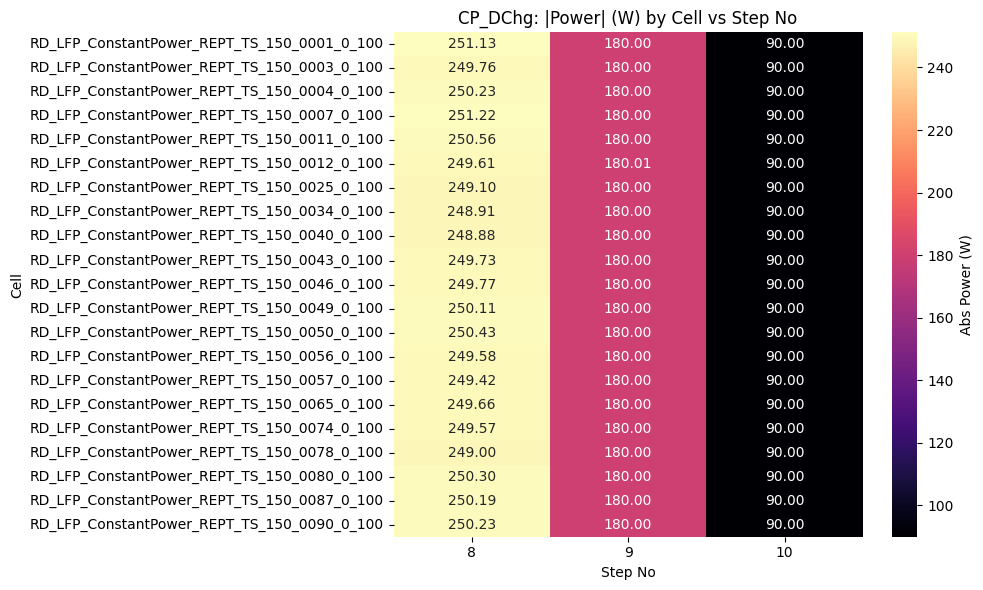

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

summary_path = Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
summary = pd.read_csv(summary_path)

cp_dchg = summary[summary["Step name"] == "CP_DChg"].copy()
cp_dchg["abs_power_W"] = cp_dchg[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

pivot = cp_dchg.pivot_table(
    index="Cell",
    columns="Step No",
    values="abs_power_W",
    aggfunc="mean",
    fill_value=0,
).sort_index()

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="magma",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Abs Power (W)"},
)
plt.title("CP_DChg: |Power| (W) by Cell vs Step No")
plt.xlabel("Step No")
plt.ylabel("Cell")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from pathlib import Path

summary = pd.read_csv(
    Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv")
)

cp_steps = summary[summary["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
cp_steps["abs_power_W"] = cp_steps[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

def expected_power(row):
    vmin, vmax = row["Volt_min"], row["Volt_max"]
    name = row["Step name"]

    if name == "CP_Chg":
        if vmax <= 3.25:
            return 90
        if vmin >= 3.25 and vmax <= 3.6:
            return 180
        if vmin >= 3.6:
            return 270
    elif name == "CP_DChg":
        if vmin >= 3.6:
            return 270
        if vmin >= 3.25 and vmax <= 3.6:
            return 180
        if vmin < 3.25 and vmax <= 3.25 and vmin >= 2.5:
            return 90
    return None  # spans multiple regions or doesn’t match rules

cp_steps["expected_power_W"] = cp_steps.apply(expected_power, axis=1)
cp_steps["power_error_W"] = cp_steps["abs_power_W"] - cp_steps["expected_power_W"]

tolerance = 5  # adjust as needed
violations = cp_steps[
    cp_steps["expected_power_W"].notna() & (cp_steps["power_error_W"].abs() > tolerance)
]

display(
    cp_steps[
        [
            "Cell",
            "Cycle No",
            "Step No",
            "Step name",
            "Volt_min",
            "Volt_max",
            "abs_power_W",
            "expected_power_W",
            "power_error_W",
        ]
    ]
)

display(violations)  # steps that differ from spec beyond tolerance


,Cell,Cycle No,Step No,Step name,Volt_min,Volt_max,abs_power_W,expected_power_W,power_error_W
1,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,4,CP_Chg,2.636974,3.250000,90.011301,90.0,0.011301
2,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,5,CP_Chg,3.260717,3.600010,180.001034,NaN,NaN
3,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,6,CP_Chg,3.601500,3.650008,270.033686,270.0,0.033686
4,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,8,CP_DChg,3.331102,3.331102,251.498224,180.0,71.498224
5,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,9,CP_DChg,3.250000,3.298147,180.000586,180.0,0.000586
...,...,...,...,...,...,...,...,...,...
560,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,5,CP_Chg,3.266687,3.600003,180.000057,NaN,NaN
561,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,6,CP_Chg,3.610323,3.650049,270.030136,270.0,0.030136
562,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,8,CP_DChg,3.301529,3.301529,249.265331,180.0,69.265331
563,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,3,9,CP_DChg,3.250000,3.307453,180.000512,180.0,0.000512


,Cell,Cycle No,Step name,Step No,Start,End,Current_min,Current_max,Capacity_min,Capacity_max,Volt_min,Volt_max,Power_min_W,Power_max_W,Duration_s,c_rate,abs_power_W,expected_power_W,power_error_W
4,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,1,CP_DChg,8,2025-11-26 16:21:46.063,2025-11-26 16:21:46.063,75.5,75.5,0.0,0.000,3.331102,3.331102,251.498224,251.498224,0.0,0.5,251.498224,180.0,71.498224
14,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,2,CP_DChg,8,2025-11-27 00:55:28.994,2025-11-27 00:55:28.994,75.5,75.5,0.0,0.001,3.330105,3.330105,251.423117,251.423117,0.0,0.5,251.423117,180.0,71.423117
22,RD_LFP_ConstantPower_REPT_TS_150_0001_0_100,3,CP_DChg,8,2025-11-27 09:31:56.432,2025-11-27 09:31:56.432,75.5,75.5,0.0,0.001,3.317604,3.317604,250.479241,250.479241,0.0,0.5,250.479241,180.0,70.479241
31,RD_LFP_ConstantPower_REPT_TS_150_0003_0_100,1,CP_DChg,8,2025-11-26 16:22:36.397,2025-11-26 16:22:36.397,75.5,75.5,0.0,0.000,3.307443,3.307443,249.711708,249.711708,0.0,0.5,249.711708,180.0,69.711708
41,RD_LFP_ConstantPower_REPT_TS_150_0003_0_100,2,CP_DChg,8,2025-11-27 00:52:59.482,2025-11-27 00:52:59.482,75.5,75.5,0.0,0.001,3.307199,3.307199,249.693310,249.693310,0.0,0.5,249.693310,180.0,69.693310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,RD_LFP_ConstantPower_REPT_TS_150_0087_0_100,2,CP_DChg,8,2025-11-27 01:01:54.134,2025-11-27 01:01:54.134,75.5,75.5,0.0,0.001,3.315752,3.315752,250.339213,250.339213,0.0,0.5,250.339213,180.0,70.339213
535,RD_LFP_ConstantPower_REPT_TS_150_0087_0_100,3,CP_DChg,8,2025-11-27 09:41:56.396,2025-11-27 09:41:56.396,75.5,75.5,0.0,0.001,3.320442,3.320442,250.693261,250.693261,0.0,0.5,250.693261,180.0,70.693261
544,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,1,CP_DChg,8,2025-11-26 16:17:35.721,2025-11-26 16:17:35.721,75.5,75.5,0.0,0.001,3.331480,3.331480,251.526457,251.526457,0.0,0.5,251.526457,180.0,71.526457
554,RD_LFP_ConstantPower_REPT_TS_150_0090_0_100,2,CP_DChg,8,2025-11-27 00:47:18.507,2025-11-27 00:47:18.507,75.5,75.5,0.0,0.001,3.310062,3.310062,249.909453,249.909453,0.0,0.5,249.909453,180.0,69.909453


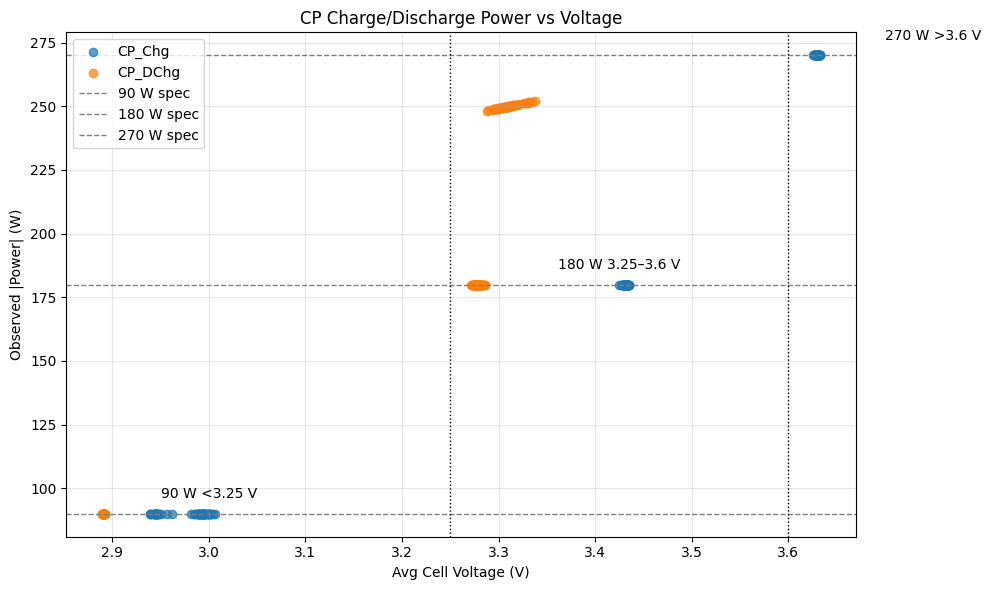

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

summary = pd.read_csv(Path("/home/kcv/Desktop/constant_power_test/post_processing/Summary/eda_summary.csv"))
cp = summary[summary["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
cp["abs_power_W"] = cp[["Power_min_W", "Power_max_W"]].abs().max(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

colors = {"CP_Chg": "tab:blue", "CP_DChg": "tab:orange"}
for step_name, group in cp.groupby("Step name"):
    ax.scatter(
        (group["Volt_min"] + group["Volt_max"]) / 2,
        group["abs_power_W"],
        c=colors[step_name],
        label=step_name,
        alpha=0.7,
    )

ax.axhline(90, color="gray", linestyle="--", linewidth=1, label="90 W spec")
ax.axhline(180, color="gray", linestyle="--", linewidth=1, label="180 W spec")
ax.axhline(270, color="gray", linestyle="--", linewidth=1, label="270 W spec")
ax.axvline(3.25, color="k", linestyle=":", linewidth=1)
ax.axvline(3.6, color="k", linestyle=":", linewidth=1)

ax.text(3.0, 95, "90 W <3.25 V", ha="center", va="bottom")
ax.text(3.425, 185, "180 W 3.25–3.6 V", ha="center", va="bottom")
ax.text(3.75, 275, "270 W >3.6 V", ha="center", va="bottom")

ax.set_xlabel("Avg Cell Voltage (V)")
ax.set_ylabel("Observed |Power| (W)")
ax.set_title("CP Charge/Discharge Power vs Voltage")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

output_dir = Path("/home/kcv/Desktop/constant_power_test/post_processing/plots")
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / "cp_power_vs_voltage.png", dpi=300)



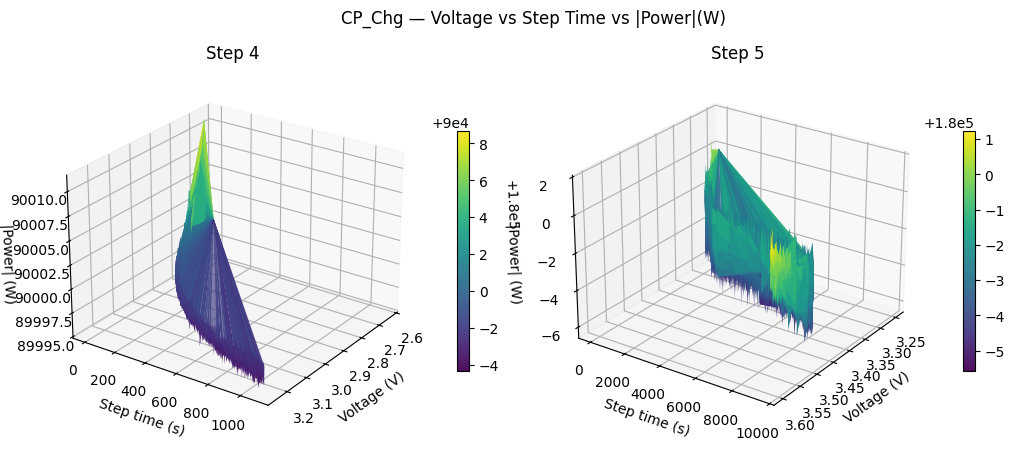

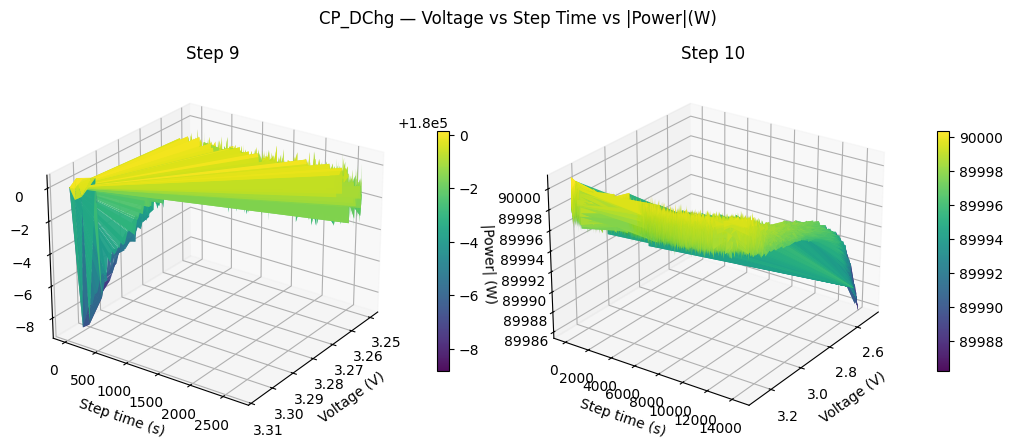

In [22]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

data_path = Path("/home/kcv/Desktop/constant_power_test/post_processing/data/RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv")
df = pd.read_csv(data_path)

df = df[df["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
df = df[df["duration"] > 10]
df["step_time_s"] = pd.to_timedelta(df["Step time(h:m:s.ms)"]).dt.total_seconds()
df["Power(W)"] = df["Power(mW)"].abs()

def plot_surface_grid(step_name: str) -> None:
    data = df[df["Step name"] == step_name]
    step_nos = sorted(data["Step No"].unique())
    if not step_nos:
        print(f"No {step_name} steps with duration >10 s in {data_path.name}")
        return

    ncols = 2
    nrows = math.ceil(len(step_nos) / ncols)
    fig = plt.figure(figsize=(5.2 * ncols, 4.5 * nrows))
    fig.suptitle(f"{step_name} — Voltage vs Step Time vs |Power|(W)")

    for idx, step_no in enumerate(step_nos, start=1):
        ax = fig.add_subplot(nrows, ncols, idx, projection="3d")
        ax.view_init(elev=25, azim=35) 
        subset = data[data["Step No"] == step_no]

        if subset["volt(V)"].nunique() < 3 or subset["step_time_s"].nunique() < 3:
            ax.text2D(0.5, 0.5, "Not enough unique points", transform=ax.transAxes, ha="center")
            ax.set_title(f"Step {step_no}")
            ax.set_axis_off()
            continue

        surf = ax.plot_trisurf(
            subset["volt(V)"],
            subset["step_time_s"],
            subset["Power(W)"],
            cmap="viridis",
            linewidth=0.2,
            alpha=0.95,
        )
        ax.set_title(f"Step {step_no}")
        ax.set_xlabel("Voltage (V)")
        ax.set_ylabel("Step time (s)")
        ax.set_zlabel("|Power| (W)")
        fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.08)

    for blank in range(len(step_nos) + 1, nrows * ncols + 1):
        fig.add_subplot(nrows, ncols, blank, projection="3d").axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_surface_grid("CP_Chg")
plot_surface_grid("CP_DChg")


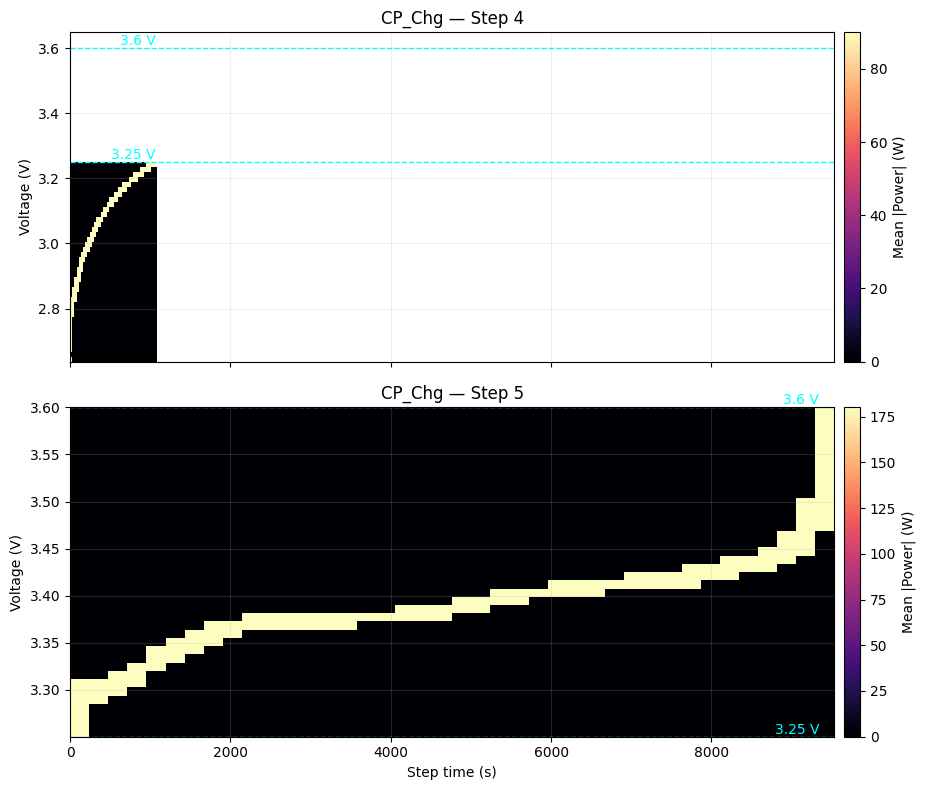

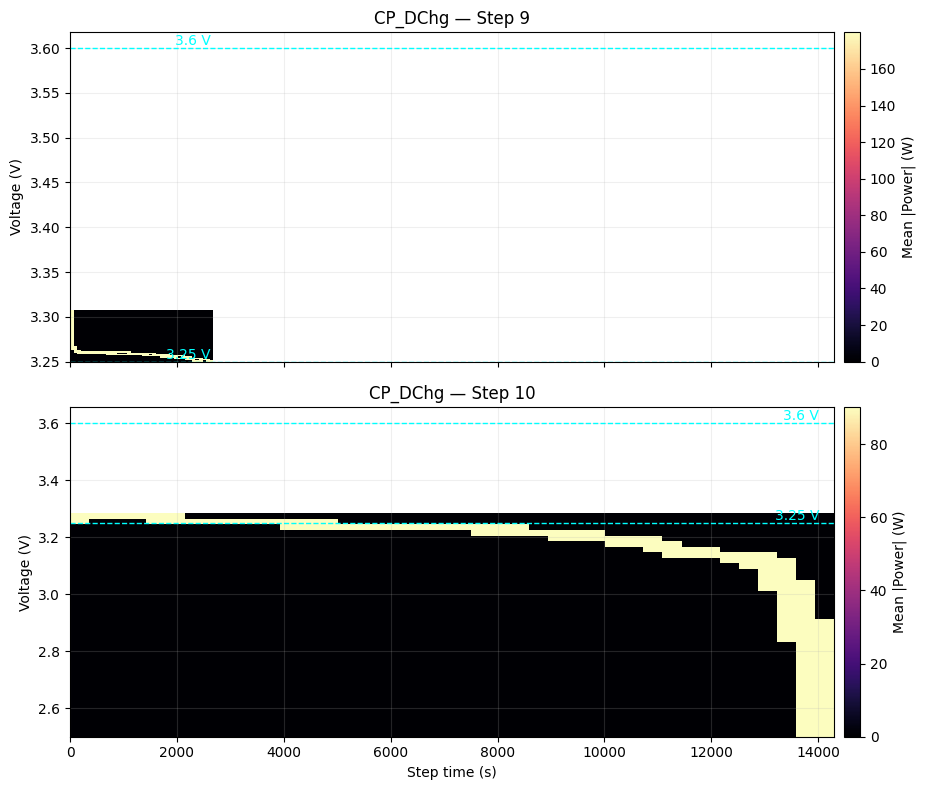

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("/home/kcv/Desktop/constant_power_test/post_processing/data/RD_LFP_ConstantPower_REPT_TS_150_0001_0_100.csv")
df = pd.read_csv(data_path)

df = df[df["Step name"].isin(["CP_Chg", "CP_DChg"])].copy()
df = df[df["duration"] > 10]
df["step_time_s"] = pd.to_timedelta(df["Step time(h:m:s.ms)"]).dt.total_seconds()
df["Power(W)"] = df["Power(mW)"].abs() / 1000

def plot_heatmap(step_name: str, bins: int = 40) -> None:
    data = df[df["Step name"] == step_name]
    if data.empty:
        print(f"No {step_name} rows in {data_path.name}")
        return

    step_nos = sorted(data["Step No"].unique())
    fig, axes = plt.subplots(len(step_nos), 1, figsize=(10, 4 * len(step_nos)), sharex=True)
    if len(step_nos) == 1:
        axes = [axes]

    for ax, step_no in zip(axes, step_nos):
        subset = data[data["Step No"] == step_no]
        if subset.empty:
            continue

        heatmap, xedges, yedges = np.histogram2d(
            subset["step_time_s"],
            subset["volt(V)"],
            bins=bins,
            weights=abs(subset["Power(W)"]),
        )
        counts, _, _ = np.histogram2d(
            subset["step_time_s"],
            subset["volt(V)"],
            bins=[xedges, yedges],
        )
        avg_power = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts > 0)

        mesh = ax.pcolormesh(
            xedges,
            yedges,
            avg_power.T,
            cmap="magma",
            shading="auto",
        )
        ax.set_title(f"{step_name} — Step {step_no}")
        ax.set_ylabel("Voltage (V)")
        ax.grid(alpha=0.2)
        fig.colorbar(mesh, ax=ax, label="Mean |Power| (W)", pad=0.01)

        ax.axhline(3.25, color="cyan", linestyle="--", linewidth=1)
        ax.axhline(3.6, color="cyan", linestyle="--", linewidth=1)
        ax.text(subset["step_time_s"].max() * 0.98, 3.25, "3.25 V", color="cyan", ha="right", va="bottom")
        ax.text(subset["step_time_s"].max() * 0.98, 3.6, "3.6 V", color="cyan", ha="right", va="bottom")

    axes[-1].set_xlabel("Step time (s)")
    plt.tight_layout()
    plt.show()

plot_heatmap("CP_Chg")
plot_heatmap("CP_DChg")
